In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from scipy.io import loadmat

from src import data, model, train

In [19]:
train_data_path = './data/train_32x32.mat'
test_data_path = './data/test_32x32.mat'

# Checking out data

In [66]:
def plot_images(data, nrows, ncols, pred_labels=None):
    fig = plt.figure(figsize=(2 * ncols, 2 * nrows))
    axes = fig.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i][0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        if pred_labels is None:
            ax.set_title('True: %d' % data[i][1])
        else:
            ax.set_title('True: {0}, Pred: {1}'.format(data[i][1], pred_labels[i]))

Ok, let's see how big is the train dataset.

In [22]:
dataset = loadmat(train_data_path)
dataset['X'].shape

(32, 32, 3, 73257)

Dimensions are weird, this won't do. I will fix them and plot some examples of data.

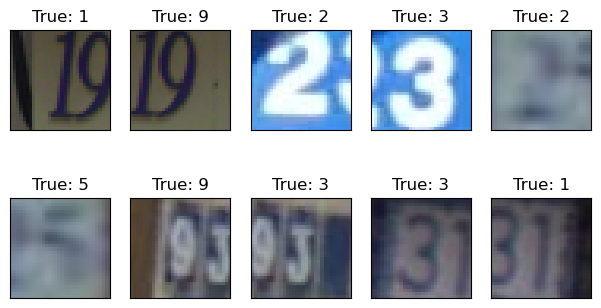

In [38]:
data = np.transpose(dataset['X'], [3, 0, 1, 2])

plot_data = list(zip(data[:10], dataset['y'][:10]))
plot_images(plot_data, nrows=2, ncols=5)

Aha, that seems in order. Images are colored, I'll greyscale them for training.

But what about balance in classes?

In [36]:
unique = np.unique(dataset['y'], return_counts=True)
unique

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8),
 array([13861, 10585,  8497,  7458,  6882,  5727,  5595,  5045,  4659,
         4948], dtype=int64))

Pupupu, that is terribly unbalanced. I will use the size of the smallest class for all classes.

Also, label '10' is for zeros, but we would need zeros themselves.

# Testing model architecture

In [79]:
def accuracy_plot(train_acc, valid_acc):
    """
    Function to plot the change of accuracy during training.
    """
    # accuracy plots
    plt.figure(figsize=(8, 5))
    plt.plot(
        train_acc, color='red', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-',
        label='validation accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

def loss_plot(train_loss, valid_loss):
    """
    Function to plot the change of loss during training.
    """
    # loss plots
    plt.figure(figsize=(8, 5))
    plt.plot(
        train_loss, color='red', linestyle='-',
        label='train loss'
    )
    if valid_loss is not None:
        plt.plot(
            valid_loss, color='blue', linestyle='-',
            label='validation loss'
        )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

Let's get our data. The preprocess is happening inside the function.

46590


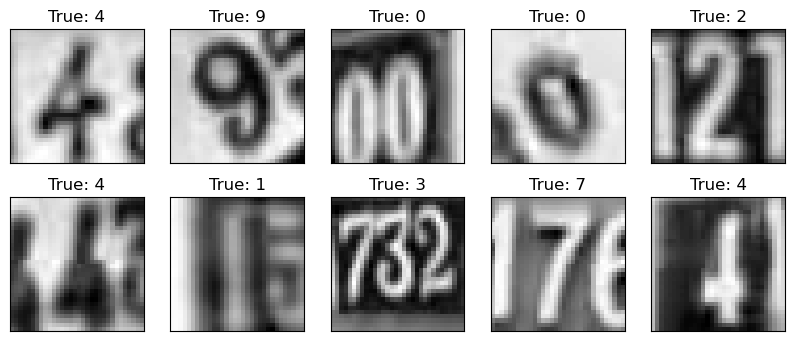

In [83]:
train_data = data.prepare_data(train_data_path)

print(len(train_data))
plot_images(train_data[:10], nrows=2, ncols=5)

See, it's already greyscale.

Now is the time to set up training: data loaders, loss function, optimiser and model itself.

In [84]:
split = int(0.8 * len(train_data))

train_loader = DataLoader(train_data[:split], batch_size=32, shuffle=False)
validation_loader = DataLoader(train_data[split:], batch_size=32, shuffle=False)

cnn_model = model.DropoutCNN(0.2)
loss_fn = torch.nn.CrossEntropyLoss()

torch.manual_seed(42)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.01)

Now I train model and get back the best checkpoint.

In [85]:
checkpoint, history = train.train_model(cnn_model, train_loader, validation_loader, 100, loss_fn, optimizer, disable_logs=True)

We all like cool graphs. Here's some cool graphs about training process.

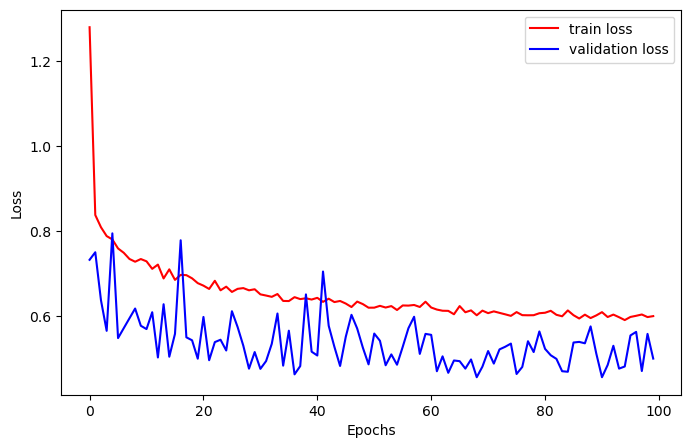

In [86]:
loss_plot(history['train_loss'], history['valid_loss'])

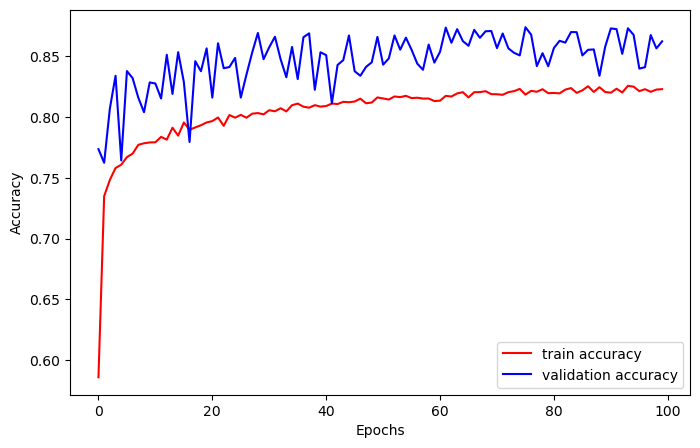

In [87]:
accuracy_plot(history['train_acc'], history['valid_acc'])

Let's see how accurate our trained model.

In [88]:
test_data = data.prepare_data(test_data_path)

test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

trained_model = model.DropoutCNN(0.2)
trained_model.load_state_dict(checkpoint['state_dict'])

test_acc, test_loss = train.step(trained_model, test_loader, loss_fn, _, test=True)
print(f'Test accuracy: {test_acc * 100:.4f}%, test loss: {test_loss:.4f}')

Test accuracy: 86.7022%, test loss: 0.4821


And now would be a good time to print some predictions, maybe I'll catch some mistakes.

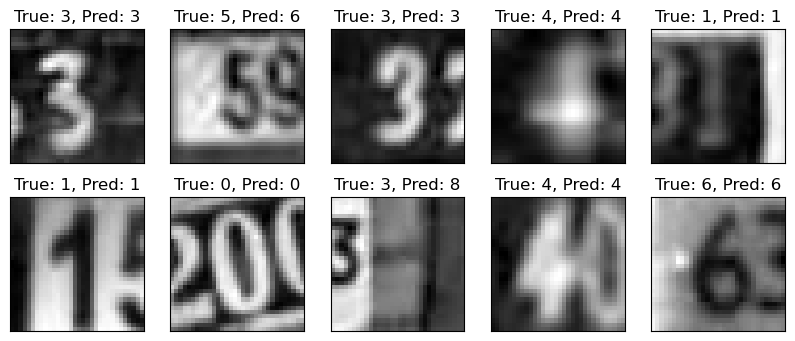

In [89]:
predict_data = test_data[:10]

trained_model.eval()

predictions = []
with torch.inference_mode():
    for image, label in predict_data:
        x = torch.tensor(image).unsqueeze(0).unsqueeze(0)
        logits = trained_model.forward(x)
        predictions.append(int(torch.argmax(logits, dim=1)))

plot_images(predict_data, nrows=2, ncols=5, pred_labels=predictions)

My verdict - this architecture is good enough for our task.

Let's save the model and move on.

In [90]:
torch.save(trained_model.state_dict(), './models/DropoutCNN_0.2_12-01-2026.pth')